# Bank Telemarketing Analysis
# Capstone Project - Group 1

# Contents:
* Exploratory Data Analysis (EDA)
* Data Preprocessing
* Classification
* Clustering
* Automation


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  auc
import pandas_profiling as pdf
import seaborn as sns
import catboost as cb
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from catboost import Pool
import lightgbm as lgb


# Loading Dataset

In [4]:
linkname = 'bank-full.csv'
df = pd.read_csv(linkname, sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.shape

(45211, 17)

In [7]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Exploratory Data Analysis (EDA)

In [8]:
# Step 1: Drop column "contact" which are useless
df=df.drop(columns=['contact'],axis=1)
# Step 2: Replace 'unknown' in job and education with 'other'
df[['job','education']] = df[['job','education']].replace(['unknown'],'other')

In [9]:
# Step 3: Change 'month' from words to numbers for easier analysis
lst = [df]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

In [10]:
df['response'] = df['y'].apply(lambda x: 0 if x == 'no' else 1)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y,month_int,response
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,unknown,no,5.0,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,unknown,no,5.0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,unknown,no,5.0,0
3,47,blue-collar,married,other,no,1506,yes,no,5,may,92,1,-1,0,unknown,no,5.0,0
4,33,other,single,other,no,1,no,no,5,may,198,1,-1,0,unknown,no,5.0,0


### Distribution of Target Variable

no     39922
yes     5289
Name: y, dtype: int64


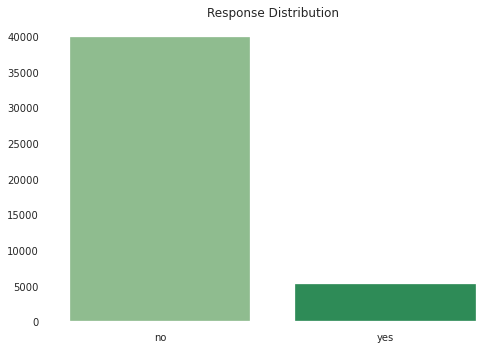

In [11]:
tcounts = df['y'].value_counts()
print(tcounts)
plt.bar(tcounts.index, tcounts.values, color=['darkseagreen','seagreen'])
plt.title("Response Distribution")
plt.show()

### Age and Balance Distribution

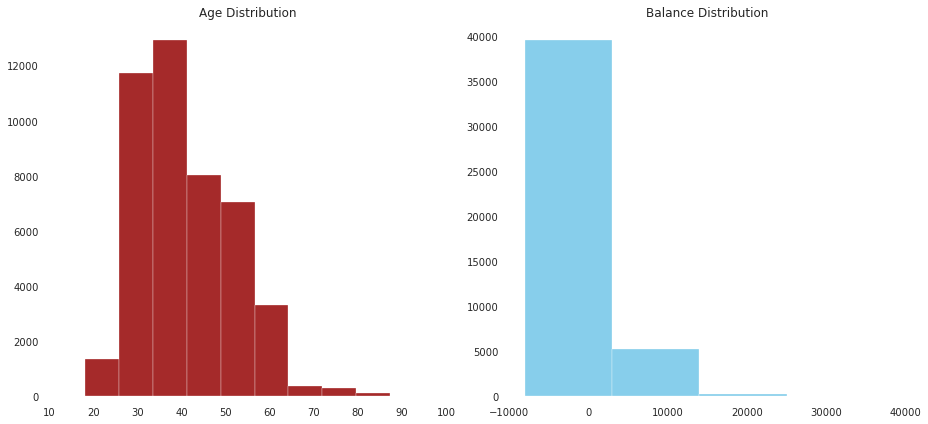

In [12]:
dist_age_balance = plt.figure(figsize = (13,6))


graph1 = dist_age_balance.add_subplot(1,2,1) 
graph2 = dist_age_balance.add_subplot(1,2,2)

graph1.set_xlim([10,100])
graph1.hist(df['age'], color='brown')
graph1.set_title('Age Distribution')
graph1.tick_params(which='minor', length=3, color='r')

#graph1.grid(True)

graph2.set_xlim([-10000,40000])
graph2.hist(df['balance'], color = 'skyblue')
graph2.set_title('Balance Distribution')
graph2.tick_params(which='minor', length=3, color='r')

plt.tight_layout() 
plt.show()

### Interpretation:

From the above Age distribution graph, we have observed that the customer's age is ranging from 18 to 95 and the maximum approached customers are having age group from around 25 to 40.

### Age and Balance Relationship

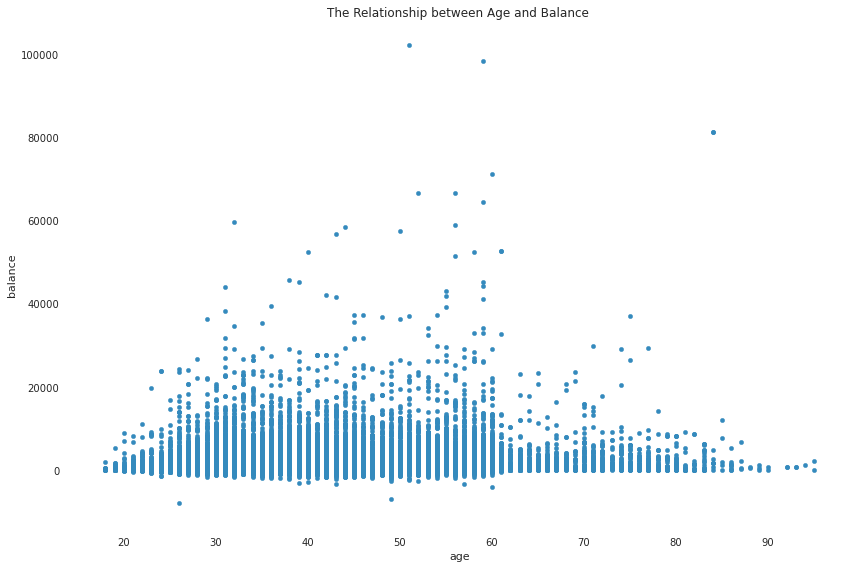

In [13]:
scatter_age_balance = df.plot.scatter('age','balance',figsize = (12,8))

plt.title('The Relationship between Age and Balance ')
plt.tight_layout() 
plt.show()

#### Interpretation:

From Age-Balance relationship, we can say that it is not depicting any major relationship among bith still we can say that customers from age group 30-60 are having quite good balance in their account. As these groups are generally fall in earning category.

### The distribution of Duration and Campaign

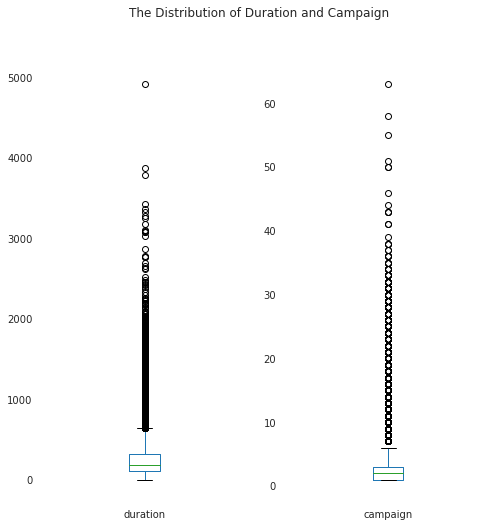

In [14]:
dist_dur_cam = df[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

#### Interpretation:

The distribution of duration: As observed from the box plot, the duration of contact has a high number of outliers, that can be reason of further study. The left-skewed boxplot indicates that most calls are relatively short.

The distribution of campagin: maximum of the clients have been contacted by the bank for the second time, while 25% was first introduced to the term deposit. Most clients have been reached by the bank for one to three times, which is reasonable. However, some clients have been contacted bank highest as 63 times, which is not normal. These clients may have some special needs that require frequent contact.

### The Scatter Matrix of Age, Balance, Duration and Campaign

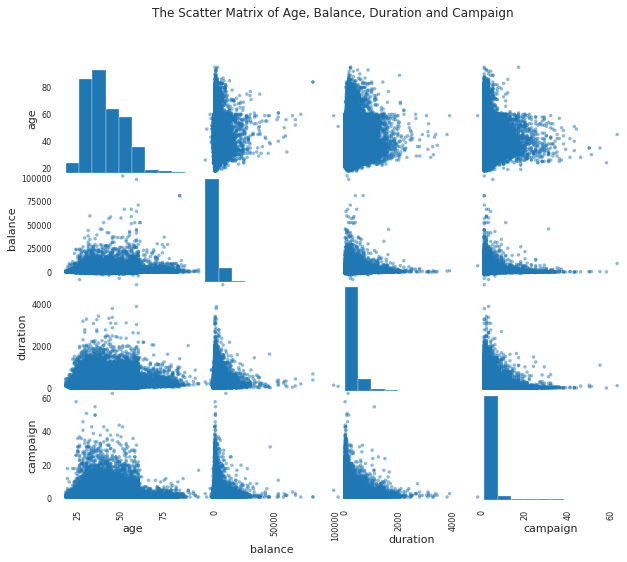

In [15]:
from pandas.plotting import scatter_matrix
matrix = scatter_matrix(df[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

### Correlation matrix

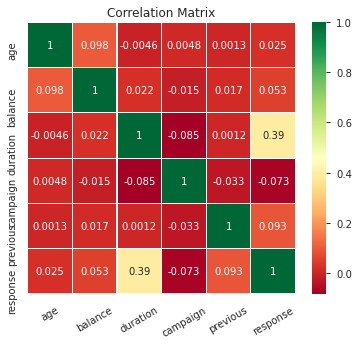

In [16]:
corr_data = df[['age','balance','duration','campaign','month','previous','response']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

#### Interpretation:

From above matrix, we can say that their is no strong relation is seen betwwen any variable. The highest observed value is 0.39 in the matrix between response and duration which also depicts weak relation between these two.

### The Relationship between the Number and Duration of Calls and Response

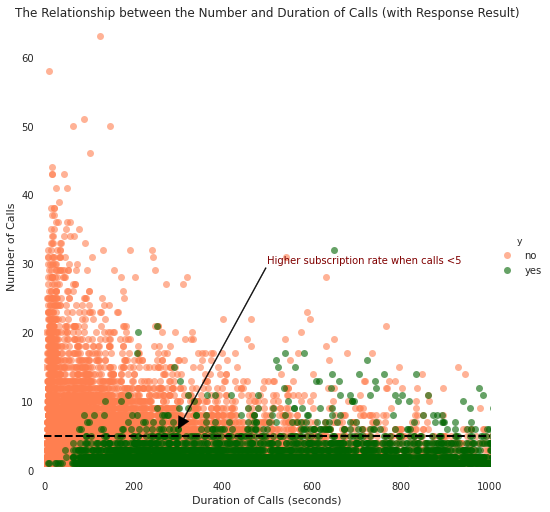

In [17]:
dur_cam = sns.lmplot(x='duration', y='campaign',
                     data = df,
                     hue ='y',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7, palette=['coral','darkgreen'])

plt.axis([0,1000,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (seconds)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (500,30),
             arrowprops=dict(color = 'k', width=1),xy=(300,6), color='maroon')
plt.show()

#### Interpretation:

From above scattered plot, we can say that “yes” customers and “no” customers are forming two relatively separate clusters. Customers who are contacted with less campaign calls (around 5) are relatively high in numbers saying yes to campaign. We can also say that those "yes" saying customers had longer conversation on calls. This depicts that bank should stop calling customers again and again from more than 5 to 10 times.

### Subscription vs. Contact Rate by Age

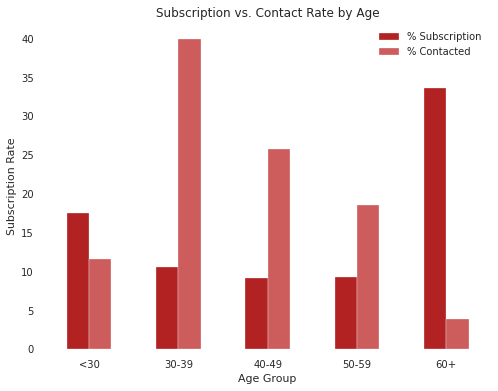

In [18]:
lst = [df]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60
count_age_response_pct = pd.crosstab(df['response'],df['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 
age = pd.DataFrame(df['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct[1]
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('firebrick','indianred'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
#plt.grid(True)
plt.show()

#### Interpretation:

From the above bar graph, we observed the following things:

1. customers having 60+ age are subscribed to the campaign highest. They are around 34% subscriptions from this age group.
2. The lowest subscriptions are from 40 to 49 age group of around 8%
3. We also saw that bank majorly focused of middle age group that is 30-50 age group people but those are having the least subscription rate.

### Subscription vs Contact Rate by Balance Level

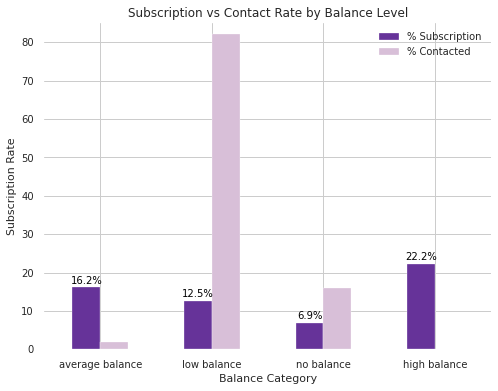

In [19]:
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 10000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 10000) & (column["balance"] <= 50000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 50000), 'balance_group'] = 'high balance'

    
    
count_balance_response_pct = pd.crosstab(df['response'],df['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()


bal = pd.DataFrame(df['balance_group'].value_counts())
bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_response_pct[1]
bal.drop('balance_group',axis = 1,inplace = True)
bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)



plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('rebeccapurple','thistle'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')
plt.ylim(0,85)



# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')
plt.grid(True)
plt.show()

#### Interpretation:

1. From above plot, we found that people who are having high balance ( more than 50000) having highest subscription rate of 22.2% to the campaign term deposit with the bank which could be the business maker for them.

2. Also, the customers who are having no balance ( negative or 0 balance) have been contacted around 18% and subscribed to term depoistion with 6.9%.

3. Customers who are having low balance (having 0 to 10000 in account) are contacted the most and their subscription rate is 12.5% which is also a quite good rate.

### The Subscription Rate of Different Balance Levels in Each Age Group

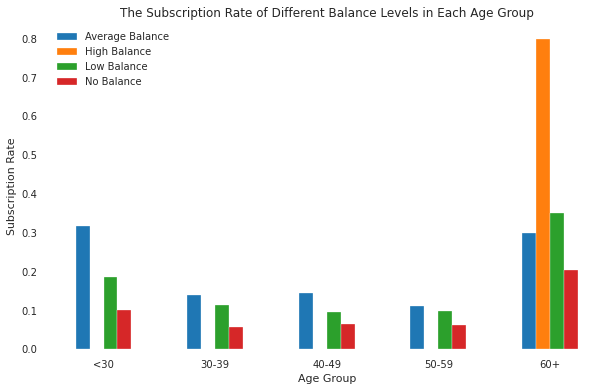

In [20]:
age_balance1 = pd.DataFrame(df.groupby(['age_group','balance_group'])['response'].sum())
age_balance2 = pd.DataFrame(df.groupby(['age_group','balance_group'])['y'].count())

age_balance1['y'] = age_balance2['y']
age_balance1['response_rate'] = age_balance1['response']/ (age_balance1['y'])
age_balance1 = age_balance1.drop(['response','y'],axis =1)

age_balance1 = age_balance1.unstack()
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

#### Interpretation:

While age represents a person’s life stage and balance represents a person’s financial condition, jointly evaluating the impact of these two factors enables us to identify which combination of client features indicates the highest likelihood of subscription.

1. From te above bar graphs, we have found that there is no customer having high balance (more than 50k) from age group of 18 to 59.

2. Who are having high balance having higher subscription rate.

3. 60+ age group are most likely intested in term deposits and having higest subsciption rate in all balance groups except average balance group.

### Subscription Rate by Job

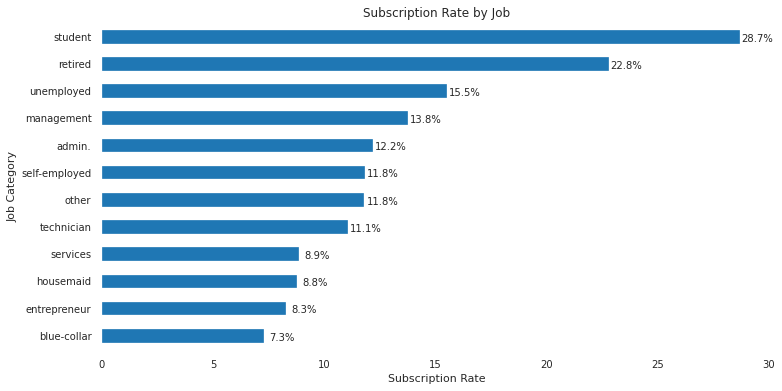

In [21]:
count_job_response_pct = pd.crosstab(df['y'],df['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

#### Interpretation:

As noted from the horizontal bar chart, students and retired customers accounted for more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.

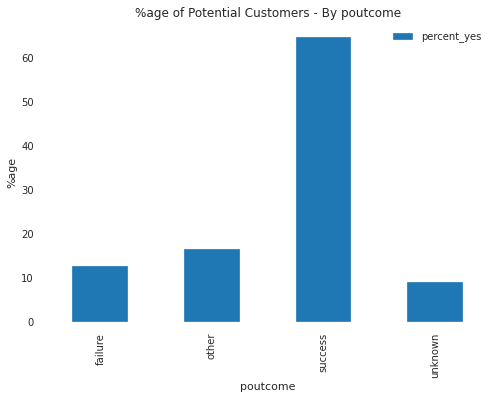

In [22]:
df1 = df.groupby(['poutcome'])['y'].count()
df2 = df[df['y'] == 'yes']
df2 = df2.groupby(['poutcome'])['y'].count()
df3 = pd.DataFrame({'poutcome': df2.index, 'yes': df2.values,'total': df1.values})
df3['percent_yes'] = df3['yes']*100/df3['total']
df3 = df3.iloc[:,[0,3]]
df3.set_index(df3.iloc[:,0].values)
df3.plot.bar(x = 'poutcome',y = 'percent_yes')
plt.title('%age of Potential Customers - By poutcome')
plt.ylabel('%age')
plt.legend()
plt.show()

### Subscription vs. Contact Rate by Month

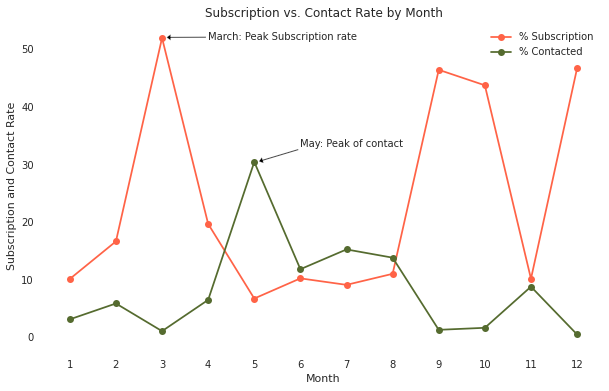

In [23]:
count_month_response_pct = pd.crosstab(df['y'],df['month_int']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df['month_int'].value_counts())
month['% Contacted'] = month['month_int']*100/month['month_int'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month_int',axis = 1,inplace = True)

month['month_int'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('month_int',ascending = True)
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o', color=['tomato','darkolivegreen'])

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

#### Interpretation:

Observations are as follows:

1. Most contacted month is MAY and after that, JUNE JULY and AUGUST.
2. Highest subscription arste is in MARCH month and after that observed in SEPTEMBER, OCTOBER adn DECEMBER month.
3. These two lines move in different directions which strongly indicates the inappropriate timing of the bank’s marketing campaign

# Preprocessing

# Changing name of target variable from 'y' to 'class'

In [52]:
linkname = 'bank-full.csv'
df = pd.read_csv(linkname, sep =';')
df.rename(index=str, columns={'y': 'class'}, inplace = True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# mapping yes,no to 1,0 and month to integers in categorical variables

In [53]:
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['class'] = df['class'].map({'yes': 1, 'no': 0})
df['month'] = df['month'].map({'jan': 1, 'feb': 2,'mar': 3,'apr': 4,'may': 5,'jun': 6,'jul': 7,'aug': 8,'sep': 9,'oct': 10,'nov': 11,'dec': 12})

In [54]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null int64
balance      45211 non-null int64
housing      45211 non-null int64
loan         45211 non-null int64
contact      45211 non-null category
day          45211 non-null int64
month        45211 non-null int64
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
class        45211 non-null int64
dtypes: category(5), int64(12)
memory usage: 4.7+ MB


# Train Test Split

In [55]:
dfi = df.drop(columns=['class'])  #independent columns
dfo = df['class']    #target column 

from sklearn.model_selection import train_test_split

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(dfi, dfo, test_size=0.2, random_state=42)

In [28]:
X_test.shape

(9043, 16)

# Target variable count


Customers who subscribed: 5289

Customers who did not subscribe: 39922



Text(0.5, 0, 'Class (0:Not_Subscribed, 1:Subscribed)')

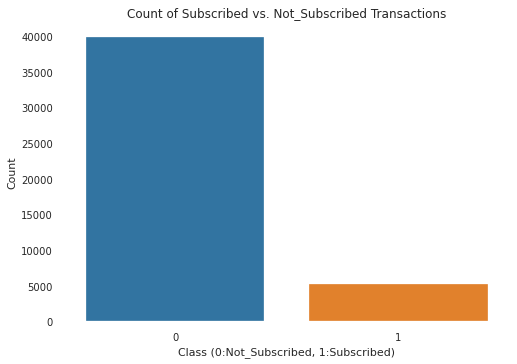

In [29]:
df['class'].value_counts()
Subscribed = df[df['class']==1]
Not_Subscribed = df[df['class']==0]

print('\nCustomers who subscribed: {}\n'.format(len(df[df['class'] == 1]))) 
print('Customers who did not subscribe: {}\n'.format(len(df[df['class'] == 0]))) 

#Ploting data of Not_Subscribed and Subscribed transaction
import seaborn as sns
counts = df['class'].value_counts()
Not_Subscribed = counts[0]
Subscribed = counts[1]
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Subscribed vs. Not_Subscribed Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Not_Subscribed, 1:Subscribed)')

# data is unbalanced

# Applying Random oversampling for balancing the data

In [56]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
not_subscribed = X[X['class']==0]
subscribed = X[X['class']==1]
# upsample minority
upsampled = resample(subscribed,
                          replace=True, # sample with replacement
                          n_samples=len(not_subscribed), # match number in majority class
                          random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled_over = pd.concat([not_subscribed, upsampled])

print("Count after Random oversampling")
print(upsampled_over['class'].value_counts())

y_train_res = upsampled_over['class']
X_train_res = upsampled_over.drop('class', axis=1)

Count after Random oversampling
1    31970
0    31970
Name: class, dtype: int64


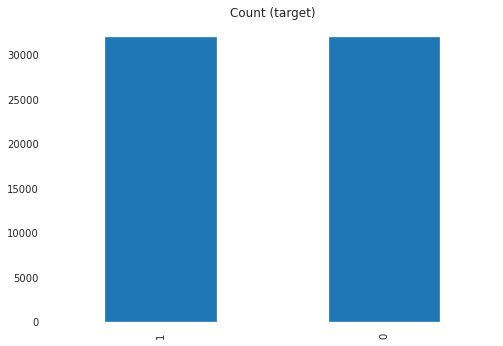

In [31]:
df_smote_over = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res, columns=['class'])], axis=1)
df_smote_over['class'].value_counts().plot(kind='bar', title='Count (target)');

# Dataset is balanced now

# Encoding of categorical variables using One Hot Encoding

In [60]:
categorical_cols=['job','education','marital','poutcome','contact']

from sklearn.feature_extraction.text import CountVectorizer

def add_onehot_to_dataframe(sparse, df, vectorizer, name):
#     This function will add the one hot encoded to the dataframe

  for i, col in enumerate(vectorizer.get_feature_names()):
    colname = name+"_"+col
    df[colname] = sparse[:, i].toarray().ravel().tolist()
  
  return df

def OneHotEncoder(categorical_cols, X_train, X_test, X_cv=None, include_cv=False):

  for i in categorical_cols:
    Vectorizer = CountVectorizer(token_pattern="[A-Za-z0-9-.]+")
    print("Encoding for feature: ", i)
    # Encoding training dataset 
    temp_cols = Vectorizer.fit_transform(X_train[i])
    X_train = add_onehot_to_dataframe(temp_cols, X_train, Vectorizer, i)
    
    # Encoding Test dataset
    temp_cols = Vectorizer.transform(X_test[i])
    X_test = add_onehot_to_dataframe(temp_cols, X_test, Vectorizer, i)
    
OneHotEncoder(categorical_cols, X_train_res,X_test,True)

# Drop the categorical features as the one hot encoded representation is present
X_train_enc = X_train_res.drop(categorical_cols, axis=1)
X_test_enc = X_test.drop(categorical_cols, axis=1)

print("Shape of train: ", X_train_enc.shape)
print("Shape of test: ", X_test_enc.shape)


Encoding for feature:  job


C:\Users\HOME\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Encoding for feature:  education
Encoding for feature:  marital
Encoding for feature:  poutcome
Encoding for feature:  contact
Shape of train:  (63940, 37)
Shape of test:  (9043, 37)


In [35]:
X_train_enc.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,contact_cellular,contact_telephone,contact_unknown
3344,41,0,849,1,0,15,5,72,1,-1,...,0,1,0,0,0,0,1,0,0,1
17965,49,0,1415,1,0,30,7,269,2,-1,...,0,1,0,0,0,0,1,1,0,0
18299,42,0,3842,0,0,31,7,130,4,-1,...,0,1,0,0,0,0,1,1,0,0
10221,37,0,-119,1,0,11,6,375,11,-1,...,0,0,1,0,0,0,1,0,0,1
23098,39,0,3867,0,0,26,8,257,12,-1,...,0,0,1,0,0,0,1,1,0,0


# Scaling

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_enc)
X_test_scaled=scaler.fit_transform(X_test_enc)

# Classification Models 

In [37]:
clsr_names=["Logistic Regression","Decision Tree", "Random Forest", "AdaBoost",
            "Naive Bayes","XGBoost"]

classifiers = [LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    xgb.XGBClassifier()]
listofdf=[]
print("Comparing different models:")
for name, clf in zip(clsr_names, classifiers):
    model=clf.fit(X_train_scaled, y_train_res)
    y_pred=model.predict(X_test_scaled)
    roc=roc_auc_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    prec = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    x=pd.DataFrame([[name, acc,prec,rec, f1,roc]],
                   columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
    listofdf.append(x)
result = pd.concat(listofdf,ignore_index=True)
result

Comparing different models:


,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.669026,0.260212,0.945921,0.408147,0.788479
1,Decision Tree,0.796638,0.298056,0.505958,0.375127,0.671238
2,Random Forest,0.875484,0.487719,0.637030,0.552464,0.772615
3,AdaBoost,0.717572,0.290341,0.928506,0.442358,0.808569
4,Naive Bayes,0.708172,0.264742,0.798350,0.397626,0.747075
5,XGBoost,0.811567,0.377742,0.868011,0.526404,0.835917


Text(0.5, 0, 'Models')

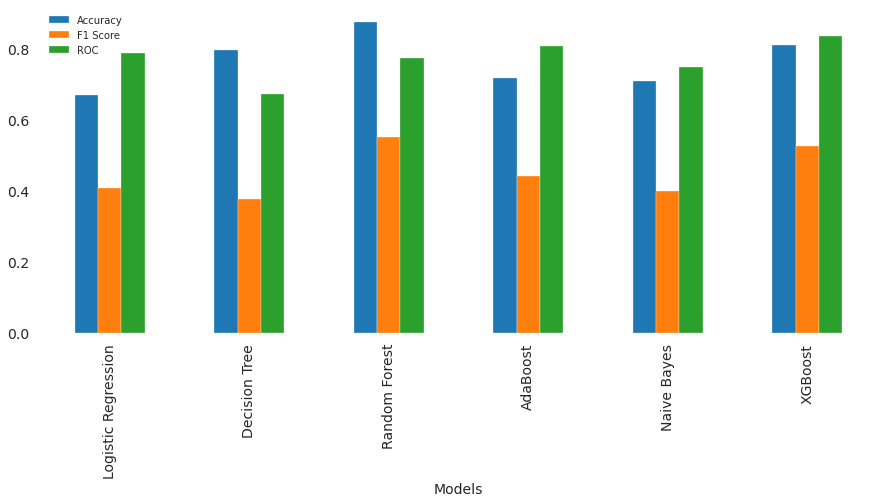

In [38]:
plt.rcParams["figure.figsize"] = (15,6)
ax = result.plot('Model',['Accuracy', 'F1 Score','ROC'] , kind='bar',fontsize = 14)
ax.set_xlabel('Models',fontsize = 14)


# Best Model : Random Forest

# But F1 score can be improved so we will try hyperparameter tuning of random forest model

In [39]:
clsr_names=["Random Forest"]
#clsr_names=["Random Forest","XGBoost"]

n_estimators = [100, 300, 500, 800, 1200, 1400, 2000]
max_depth = [5, 8, 15, 25, 30, 40, 100]
min_samples_split = [2, 5, 10, 15, 100, 500, 1000]
min_samples_leaf = [1, 2, 5, 10, 20, 50, 200] 
random_state = [0, 10, 20, 50, 100, 500, 1000]
#bootstrap = ['True','False']
#max_features = ['auto','sqrt']

for i in range(0,7):
  classifiers = [RandomForestClassifier(n_estimators = n_estimators[i], max_depth = max_depth[i], min_samples_split = min_samples_split[i], min_samples_leaf = min_samples_leaf[i],
                                        max_features='sqrt', bootstrap=False, random_state= random_state[i])]
  print("Comparing with tuning different parameters in models:")
  for name, clf in zip(clsr_names, classifiers):
    rf=clf.fit(X_train_scaled, y_train_res)
    y_pred_rf=rf.predict(X_test_scaled)
    print(name+" Accuracy: {0:.3f}".format(accuracy_score(y_test,y_pred)))
    print(name+" F1 Score: {0:.3f}".format(f1_score(y_test,y_pred)))
    print(name+" precision Score: {0:.3f}".format(precision_score(y_test,y_pred)))
    print(name+" recall Score: {0:.3f}".format(recall_score(y_test,y_pred)))
    print(name+" AUC-ROC: {0:.3f}\n".format(roc_auc_score(y_test,y_pred)))

Comparing with tuning different parameters in models:
Random Forest Accuracy: 0.812
Random Forest F1 Score: 0.526
Random Forest precision Score: 0.378
Random Forest recall Score: 0.868
Random Forest AUC-ROC: 0.836

Comparing with tuning different parameters in models:
Random Forest Accuracy: 0.812
Random Forest F1 Score: 0.526
Random Forest precision Score: 0.378
Random Forest recall Score: 0.868
Random Forest AUC-ROC: 0.836

Comparing with tuning different parameters in models:
Random Forest Accuracy: 0.812
Random Forest F1 Score: 0.526
Random Forest precision Score: 0.378
Random Forest recall Score: 0.868
Random Forest AUC-ROC: 0.836

Comparing with tuning different parameters in models:
Random Forest Accuracy: 0.812
Random Forest F1 Score: 0.526
Random Forest precision Score: 0.378
Random Forest recall Score: 0.868
Random Forest AUC-ROC: 0.836

Comparing with tuning different parameters in models:
Random Forest Accuracy: 0.812
Random Forest F1 Score: 0.526
Random Forest precision Sc

In [34]:
rf=RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf=rf.predict(X_test_scaled)
roc=roc_auc_score(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test,y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

random = pd.DataFrame([['Random Forest', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
random

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest,0.875484,0.487956,0.649863,0.55739,0.778151


In [41]:
# function to produce confusion matrix
def plot_cm(y_test, y_pred_rf):
    cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(1, figsize=(6,6))
    sns.heatmap(cm, cmap= "RdGy", annot=annot, fmt='', ax=ax)

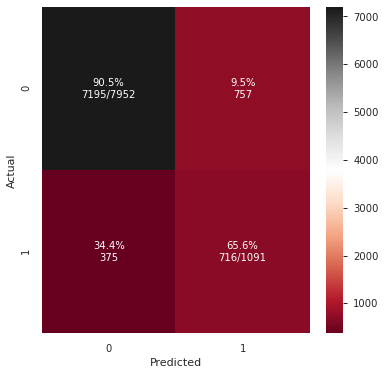

In [42]:
plot_cm(y_test, y_pred_rf)

roc_auc_score for Random Forest:  0.9099750888465532


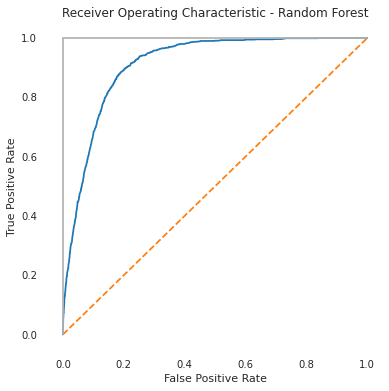

In [43]:
# Get predicted probabilities
y_score1 = rf.predict_proba(X_test_scaled)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))
    
# Plot ROC curves
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest results are still not satisfactory. So we will try CatBoost and light GMB Classifiers to see if scores can be improved.

# CatBoost Classifier

In [20]:
category_cols = ['job','marital','education','poutcome','contact']
for header in category_cols:
    X_train_res[header] = X_train_res[header].astype('category').cat.codes
    X_test[header] = X_test[header].astype('category').cat.codes

C:\Users\HOME\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
clf = cb.CatBoostClassifier(eval_metric="AUC",depth=5, iterations= 300, l2_leaf_reg= 6, learning_rate= 0.15)
clf.fit(X_train_res, y_train_res)

0:	total: 455ms	remaining: 2m 15s
1:	total: 491ms	remaining: 1m 13s
2:	total: 531ms	remaining: 52.6s
3:	total: 573ms	remaining: 42.4s
4:	total: 608ms	remaining: 35.9s
5:	total: 649ms	remaining: 31.8s
6:	total: 743ms	remaining: 31.1s
7:	total: 800ms	remaining: 29.2s
8:	total: 853ms	remaining: 27.6s
9:	total: 888ms	remaining: 25.8s
10:	total: 927ms	remaining: 24.4s
11:	total: 981ms	remaining: 23.5s
12:	total: 1.02s	remaining: 22.6s
13:	total: 1.07s	remaining: 21.9s
14:	total: 1.11s	remaining: 21.1s
15:	total: 1.15s	remaining: 20.5s
16:	total: 1.21s	remaining: 20.2s
17:	total: 1.25s	remaining: 19.6s
18:	total: 1.3s	remaining: 19.2s
19:	total: 1.34s	remaining: 18.8s
20:	total: 1.39s	remaining: 18.5s
21:	total: 1.43s	remaining: 18.1s
22:	total: 1.48s	remaining: 17.8s
23:	total: 1.53s	remaining: 17.6s
24:	total: 1.58s	remaining: 17.4s
25:	total: 1.62s	remaining: 17.1s
26:	total: 1.66s	remaining: 16.8s
27:	total: 1.73s	remaining: 16.8s
28:	total: 1.81s	remaining: 16.9s
29:	total: 1.88s	remain

241:	total: 11.5s	remaining: 2.75s
242:	total: 11.5s	remaining: 2.71s
243:	total: 11.6s	remaining: 2.66s
244:	total: 11.6s	remaining: 2.61s
245:	total: 11.7s	remaining: 2.56s
246:	total: 11.7s	remaining: 2.51s
247:	total: 11.7s	remaining: 2.46s
248:	total: 11.8s	remaining: 2.41s
249:	total: 11.8s	remaining: 2.37s
250:	total: 11.9s	remaining: 2.32s
251:	total: 11.9s	remaining: 2.27s
252:	total: 12s	remaining: 2.22s
253:	total: 12s	remaining: 2.17s
254:	total: 12s	remaining: 2.12s
255:	total: 12.1s	remaining: 2.08s
256:	total: 12.1s	remaining: 2.03s
257:	total: 12.2s	remaining: 1.98s
258:	total: 12.2s	remaining: 1.93s
259:	total: 12.2s	remaining: 1.88s
260:	total: 12.3s	remaining: 1.83s
261:	total: 12.3s	remaining: 1.79s
262:	total: 12.4s	remaining: 1.74s
263:	total: 12.4s	remaining: 1.69s
264:	total: 12.5s	remaining: 1.65s
265:	total: 12.6s	remaining: 1.6s
266:	total: 12.6s	remaining: 1.56s
267:	total: 12.6s	remaining: 1.51s
268:	total: 12.7s	remaining: 1.46s
269:	total: 12.7s	remaining

In [22]:
y_predict = clf.predict(X_test)
roc=roc_auc_score(y_test, y_predict)
acc = accuracy_score(y_test, y_predict)
prec = precision_score(y_test, y_predict)
rec = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

cat = pd.DataFrame([['CatBoost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
cat

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,CatBoost,0.866084,0.470385,0.873511,0.611485,0.869288


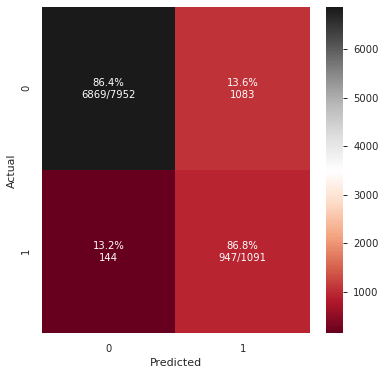

In [48]:
plot_cm(y_test, y_predict)

roc_auc_score for CatBoost:  0.935441590883523


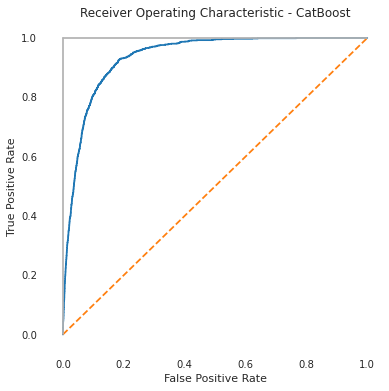

In [49]:
# Get predicted probabilities
y_score1 = clf.predict_proba(X_test)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for CatBoost: ', roc_auc_score(y_test, y_score1))
    
# Plot ROC curves
plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - CatBoost')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Light GBM Classifier

In [57]:
d_train = lgb.Dataset(X_train_res, label=y_train_res)
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['num_leaves'] = 15
params['min_data'] = 50
params['max_depth'] = 10
params['max_bin'] = 120
lg = lgb.train(params, d_train, 10000)

In [58]:
# save the model
import pickle
filename = 'E:/final_model.sav'
pickle.dump(lg, open(filename, 'wb'))

In [59]:
#Prediction
y_pred=lg.predict(X_test)
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:       
       y_pred[i]=1
    else:  
       y_pred[i]=0
    
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [25]:
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

gm = pd.DataFrame([['LGMBoost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
gm

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,LGMBoost,0.879686,0.500838,0.821265,0.622222,0.854483


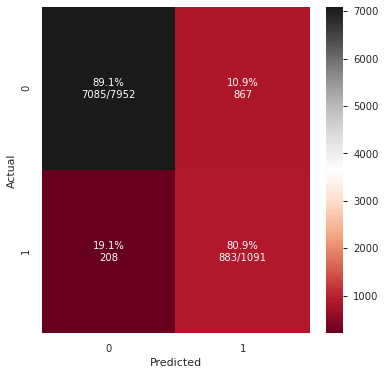

In [60]:
plot_cm(y_test, y_pred)

roc_auc_score for Light GBM:  0.9298781921593724


<Figure size 1080x432 with 0 Axes>

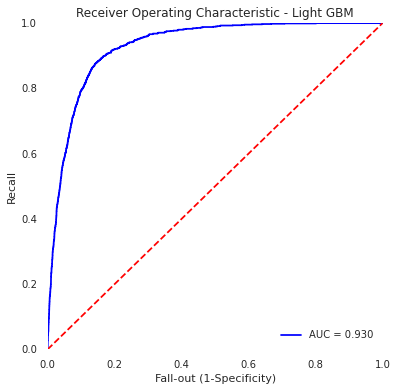

In [61]:
#Print Area Under Curve
plt.figure()
plt.subplots(1, figsize=(6,6))
false_positive_rate, recall, thresholds = roc_curve(y_test, lg.predict(X_test))
roc_auc = auc(false_positive_rate, recall)
print('roc_auc_score for Light GBM: ', roc_auc_score(y_test, lg.predict(X_test)))
plt.title('Receiver Operating Characteristic - Light GBM')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()


# Explaining the lightgbm model features

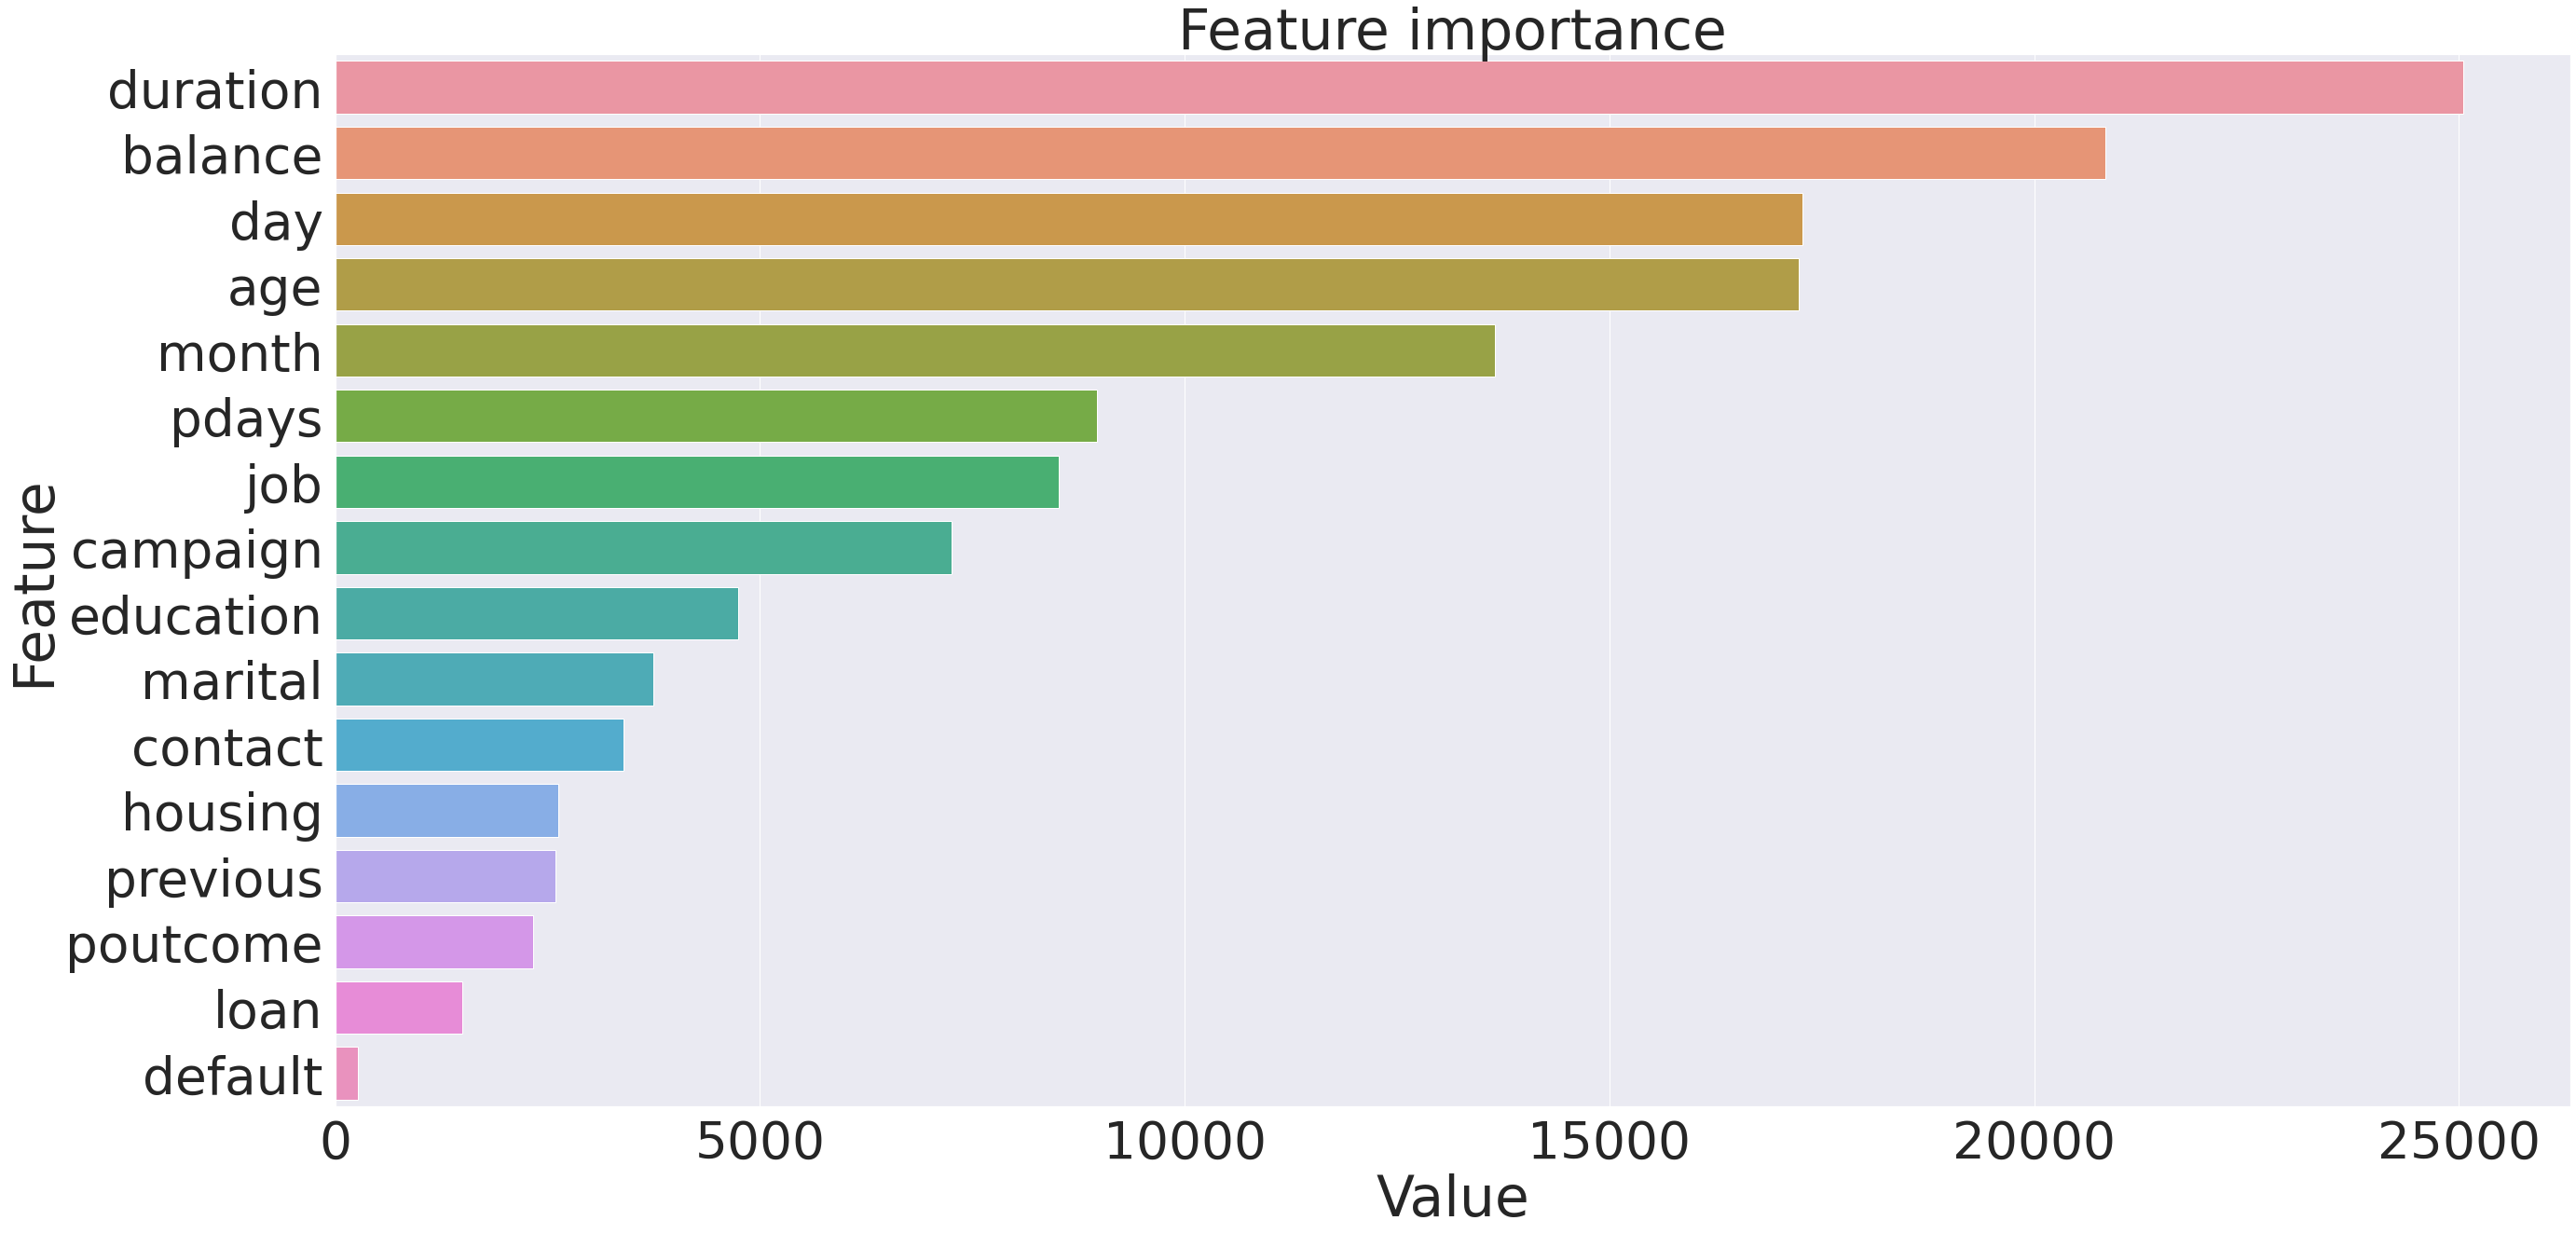

In [62]:
def plotImp(lg, X_test , num = 20):
    feature_imp = pd.DataFrame({'Value':lg.feature_importance(),'Feature':X_test.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Feature importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(lg, X_test , num = 20)

In [35]:
listof=[random,cat,gm]
res=pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
listof.append(res)
result = pd.concat(listof,ignore_index=True)
result

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest,0.875484,0.487956,0.649863,0.557390,0.778151
1,CatBoost,0.866084,0.470385,0.873511,0.611485,0.869288
2,LGMBoost,0.879686,0.500838,0.821265,0.622222,0.854483


Text(0.5, 0, 'Models')

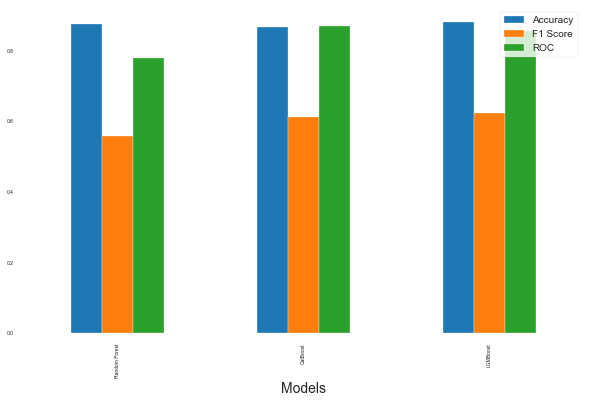

In [37]:
plt.rcParams["figure.figsize"] = (10,6)
ax = result.plot('Model',['Accuracy', 'F1 Score','ROC'] , kind='bar',fontsize = 5)
ax.set_xlabel('Models',fontsize = 14)


# Best model for classification: LightGBM 

# Explain model using Shap Values

In [65]:
categorical_features_indices = np.where(X_train_res.dtypes != np.int64)[0]

In [66]:

import shap
explainer = shap.TreeExplainer(model=lg, data=None, model_output='raw', feature_perturbation='tree_path_dependent')


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [67]:
shap_values=explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [68]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1][0,:],features=X_test.iloc[0,:])

In [69]:
shap.force_plot(explainer.expected_value[1],shap_values[1][7,:],features=X_test.iloc[7,:])

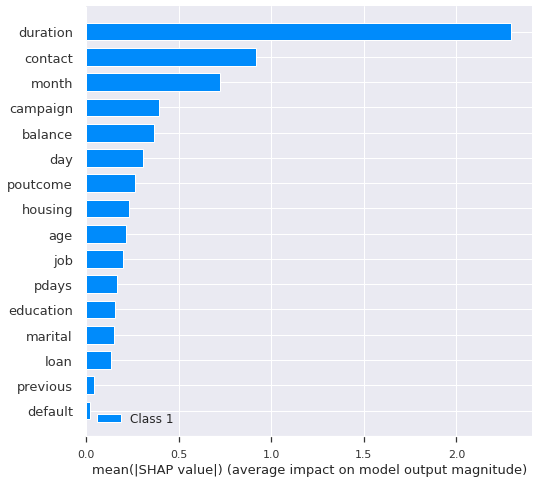

In [70]:
shap.summary_plot(shap_values, features=X_test, class_inds=[1])

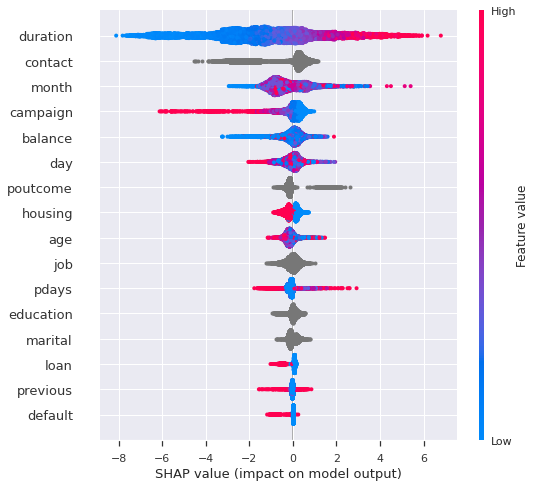

In [71]:
shap.summary_plot(shap_values[1],features=X_test)

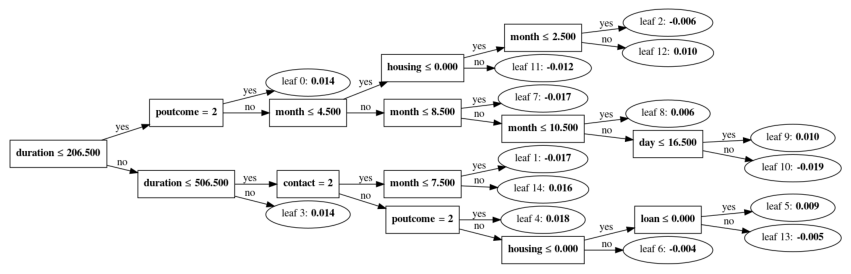

In [72]:
lgb.plot_tree(lg, ax=None, tree_index=0, figsize=None, dpi=None, show_info=None, precision=3)

In [73]:
ax = lgb.create_tree_digraph(lg)
with open('fst.svg', 'w') as f:
    f.write(ax._repr_svg_())

## Implementing Deep Learning Network


In [74]:
#!pip install wrapt --upgrade --ignore-installed
#!pip install tensorflow-gpu
import keras
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense
classifier = Sequential()

In [75]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 37, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37))

# Adding the second hidden layer
classifier.add(Dense(units = 18, kernel_initializer = 'uniform', activation = 'relu'))


# Adding the third hidden layer
classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))


# Adding the fourth hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train_scaled, y_train_res.values, batch_size = 10, epochs = 50,verbose = 0)

score, acc = classifier.evaluate(X_train_scaled, y_train_res.values,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc) 
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test_scaled)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test_scaled, y_test.values,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

6394/6394 [==============================] - 8s 1ms/step - loss: 0.2253 - accuracy: 0.9186
Train score: 0.22530125081539154
Train accuracy: 0.9186424612998962
********************
905/905 [==============================] - 1s 2ms/step - loss: 0.6525 - accuracy: 0.7169
Test score: 0.6525107622146606
Test accuracy: 0.7169080972671509
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      7952
           1       0.29      0.91      0.44      1091

    accuracy                           0.72      9043
   macro avg       0.64      0.80      0.62      9043
weighted avg       0.90      0.72      0.77      9043



## K Means Clustering

In [3]:
# Import label encoder 
from scipy import stats
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from scipy import stats
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()

In [4]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [5]:
df['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [6]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [7]:
# Encode labels in column 'marital'. 
df['marital']= label_encoder.fit_transform(df['marital']) 
df['marital'].head()

0    1
1    2
2    1
3    1
4    2
Name: marital, dtype: int32

In [8]:
# Encode labels in column 'education'. 
df['education']= label_encoder.fit_transform(df['education']) 
df['education'].head()

0    2
1    1
2    1
3    3
4    3
Name: education, dtype: int32

In [9]:
# Encode labels in column 'job'. 
df['job']= label_encoder.fit_transform(df['job']) 
df['job'].head()

0     4
1     9
2     2
3     1
4    11
Name: job, dtype: int32

In [10]:
df_clus = df.loc[:, ['age','balance']]
df_clus.head()

,age,balance
0,58,2143
1,44,29
2,33,2
3,47,1506
4,33,1


##Using the elbow method to find the optimum number of clusters

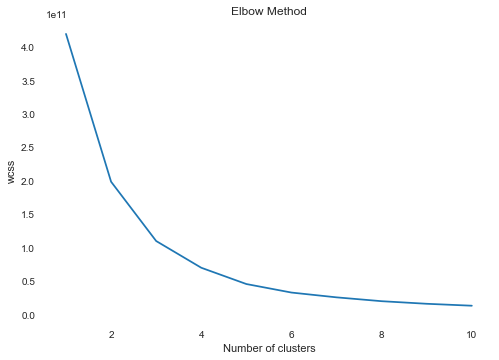

In [11]:
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_clus)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

###The optimum number of clusters are 4,5 or 6
###Lets take 4 cluster

In [12]:
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(df_clus)

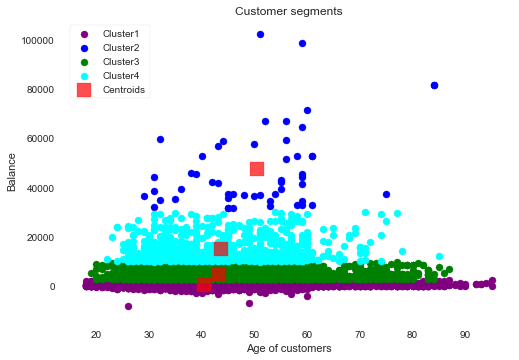

In [13]:
#Visualizing the clusters for k=4
df_clus = np.array(df_clus)
plt.scatter(df_clus[y_means==0,0],df_clus[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(df_clus[y_means==1,0],df_clus[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(df_clus[y_means==2,0],df_clus[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(df_clus[y_means==3,0],df_clus[y_means==3,1],s=50, c='cyan',label='Cluster4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments')
plt.xlabel('Age of customers')
plt.ylabel('Balance')
plt.legend()
plt.show()

Significance of Clusters Cluster 1 Indicates very low balance through out 20 to 90 years of age of people Cluster 2 indicates 35000 to around 85-90000 in age group 30 to 60 Cluster 3 indicates low balance through out 20 to 85 years of age Cluster 4 indicates 15000 to 35000 balance and 25 to 75 years of age of people

Potential Customer Segment Cluster 2 seems potential customer segment and cluster 4 also seems good enough for bank telemarketing.. Cluster 1 and 3 can be segmented further to arrive at a more specific target customer group.

# AUTOMATION 

In [63]:
categorical_cols=['job','education','marital','poutcome','contact']

In [64]:
def OneHotEncodeColumns(inp_df):
    
    """  Employee Job  """
    management, technician, blue_collar, selfemployed, admin, entrepreneur, housemaid, retired, services, student, unemployed,unknown = 0,0,0,0,0,0,0,0,0,0,0,0

    job = inp_df["job"].iloc[0]
    job

    if job.lower() == "management":
        management = 1
    elif job.lower() == "technician".lower():
        technician = 1
    elif job.lower() == "blue-collar".lower():
        blue_collar = 1
    elif job.lower() == "selfemployed".lower():
        selfemployed = 1
    elif job.lower() == "admin".lower():
        admin = 1
    elif job.lower() == "entrepreneur".lower():
        entrepreneur = 1
    elif job.lower() == "housemaid".lower():
        housemaid = 1
    elif job.lower() == "retired".lower():
        retired = 1
    elif job.lower() == "services".lower():
        services = 1
    elif job.lower() == "student".lower():
        student = 1
    elif job.lower() == "unemployed".lower():
        unemployed = 1
    elif job.lower() == "unknown".lower():
        unknown = 1


    #print(Employed, Unemployed, Medical_Leave, Disabled, Retired)
    inp_df["job_management"] = management
    inp_df["job_technician"] = technician
    inp_df["job_blue-collar"] = blue_collar
    inp_df["job_self-employed"] = selfemployed
    inp_df["job_admin."] = admin
    inp_df["job_entrepreneur"] = entrepreneur
    inp_df["job_housemaid"] = housemaid
    inp_df["job_retired"] = retired
    inp_df["job_services"] = services
    inp_df["job_student"] = student
    inp_df["job_unemployed"] = unemployed
    inp_df["job_unknown"] = unknown


    """ Marital Status """
    married, single, divorced = 0,0,0

    marStatus = inp_df["marital"].iloc[0]
    marStatus

    if marStatus.lower() == "divorced".lower():
        divorced = 1
    elif marStatus.lower() == "married".lower():
        married = 1
    elif marStatus.lower() == "single".lower():
        single = 1
    
    inp_df["marital_married"] = married
    inp_df["marital_single"] = single
    inp_df["marital_divorced"] = divorced
    
    
    """ Education """
    primary, secondary, tertiary,unknown = 0,0,0,0

    edu = inp_df["education"].iloc[0]
    edu

    if edu.lower() == "primary".lower():
        primary = 1
    elif edu.lower() == "secondary".lower():
        secondary = 1
    elif edu.lower() == "tertiary".lower():
        tertiary = 1
    elif edu.lower() == "unknown".lower():
        unknown = 1
    
    inp_df["education_primary"] = primary
    inp_df["education_secondary"] = secondary
    inp_df["education_tertiary"] = tertiary
    inp_df["education_unknown"] = unknown
    
    
    """ poutcome """
    success, failure, other,unknown = 0,0,0,0

    poutcome = inp_df["poutcome"].iloc[0]
    poutcome

    if poutcome.lower() == "success".lower():
        success = 1
    elif poutcome.lower() == "failure".lower():
        failure = 1
    elif poutcome.lower() == "other".lower():
        other = 1
    elif poutcome.lower() == "unknown".lower():
        unknown = 1
    
    inp_df["poutcome_success"] = success
    inp_df["poutcome_failure"] = failure
    inp_df["poutcome_other"] = other
    inp_df["poutcome_unknown"] = unknown
    
    """ contact """
    telephone, cellular, unknown = 0,0,0

    poutcome = inp_df["contact"].iloc[0]
    poutcome

    if poutcome.lower() == "telephone".lower():
        telephone = 1
    elif poutcome.lower() == "cellular".lower():
        cellular = 1
    elif poutcome.lower() == "unknown".lower():
        unknown = 1
    
    inp_df["contact_telephone"] = telephone
    inp_df["contact_cellular"] = cellular
    inp_df["contact_unknown"] = unknown
    
    
    """ Remove the columns one-hot encoded """
    inp_df = inp_df.drop(["job", "marital", "education", "poutcome",'contact'], axis = 1)
    
    return inp_df 

In [65]:
loaded_model = pickle.load(open(filename, 'rb'))

In [66]:
print("-----------------------------BANK TELEMARKETING-------------------------")
print("-----------------PREDICT IF CUSTOMER IS A POTENTIAL BUYER OR NOT!!------")
print("-----------------------------ENTER DETAILS BELOW :------------------------")

age=int(input("Age of the customer :"))
job=input("Job of the customer :")
marital=input("Enter Marital Status:")
education=input("Enter education:")
default=int(input("Do customer has credit in default? (no:0, yes:1):"))
balance=int(input("Enter average yearly bank balance:"))
housing=int(input("Do Customer has Housing Loan? (no:0, yes:1):"))
loan=int(input("Do Customer has Personal Loan? (no:0, yes:1):"))
contact=input("Enter contact communication type:")
day=int(input("Enter day of the month:"))
month =int(input("Enter month:"))
duration=int(input("Enter average call duration:"))
campaign=int(input("Number of contacts performed during this campaign for this client:"))
pdays=int(input("Number of days since the client was last contacted in a previous campaign(-1 for first time):"))
previous=int(input("Number of contacts performed before this campaign for this client:"))
poutcome=input("Outcome of the previous marketing campaign:")
tes=pd.DataFrame(data=[[age, job, marital, education, default, balance, housing,
       loan, contact, day, month, duration, campaign, pdays,
       previous, poutcome]],columns=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'])
#tes=user_input

print("\nCOMPARING DIFFERENT MODELS:")
    
for c in tes.columns:
    col_type = tes[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        tes[c] = tes[c].astype('category')
#Prediction
y_pred=loaded_model.predict(tes)
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:       
       y_pred[i]=1
       print("\nLIGHT GBM (Best Model): The person is a potential customer ")
    else:  
       y_pred[i]=0
       print("\nLIGHT GBM (Best Model): The person is not a potential customer ")

pred = OneHotEncodeColumns(tes)
lr  = LogisticRegression()
model = lr.fit(X_train_scaled, y_train_res)
a=model.predict(pred)
if a==1:
    print("\nLogistic Regression : The person is a potential customer")
else:
    print("\nLogistic Regression : The person is NOT a potential customer")

dr  = DecisionTreeClassifier()
model = dr.fit(X_train_scaled, y_train_res)
a=model.predict(pred)
if a==1:
    print("\nDecision Tree : The person is a potential customer")
else:
    print("\nDecision Tree : The person is NOT a potential customer")

rf  = RandomForestClassifier()
model = rf.fit(X_train_scaled, y_train_res)
a=model.predict(pred)
if a==1:
    print("\nRandom Forest : The person is a potential customer")
else:
    print("\nRandom Forest : The person is NOT a potential customer")

ab  = AdaBoostClassifier()
model = ab.fit(X_train_scaled, y_train_res)
a=model.predict(pred)
if a==1:
    print("\nAdaBoost : The person is a potential customer")
else:
    print("\nAdaBoost : The person is NOT a potential customer")
    
gb  = GaussianNB()
model = gb.fit(X_train_scaled, y_train_res)
a=model.predict(pred)
if a==1:
    print("\nGaussianNB : The person is a potential customer")
else:
    print("\nGaussianNB : The person is NOT a potential customer")
    

-----------------------------BANK TELEMARKETING-------------------------
-----------------PREDICT IF CUSTOMER IS A POTENTIAL BUYER OR NOT!!------
-----------------------------ENTER DETAILS BELOW :------------------------
Age of the customer :70
Job of the customer :retired
Enter Marital Status:married
Enter education:secondary
Do customer has credit in default? (no:0, yes:1):0
Enter average yearly bank balance:3000
Do Customer has Housing Loan? (no:0, yes:1):0
Do Customer has Personal Loan? (no:0, yes:1):0
Enter contact communication type:cellular
Enter day of the month:5
Enter month:3
Enter average call duration:374
Number of contacts performed during this campaign for this client:1
Number of days since the client was last contacted in a previous campaign(-1 for first time):1
Number of contacts performed before this campaign for this client:1
Outcome of the previous marketing campaign:unknown

COMPARING DIFFERENT MODELS:

LIGHT GBM (Best Model): The person is a potential customer 

Lo